# Synchrotron Radiation

## Pre-Requisites
As usual, we start with importing the necessary modules.

In [1]:
from astropy import units as u
from astropy import constants as c

from astropy.modeling.powerlaws import PowerLaw1D

import numpy as np

import matplotlib.pyplot as plt

from math import pi
from numpy import sqrt, cos, sin, tan, abs

## Relativistic Gyro-Frequency

Let's declare a function to calculate the gyro-frequency, as on the lecture slides on page 27. It takes as parameters the magnetic field B, the Lorentz factor $\gamma$, the charge q in elementary charges with -1 as default and the mass of the particle with the electron mass as default.

In [2]:
def omega_r(B, gamma, q = -1, m = c.m_e) :
    
    # convert q into charge
    q *= c.e.si
    
    # we only need the magnitude of the charge:
    q = abs(q)
    
    # equation as on the lecture slides
    omega_r = q*B/(gamma*m)
    
    # return omega_r in units of Hz
    return omega_r.to(u.Hz)

This function takes the Lorentz factor $\gamma$ as parameter. But often we have the total energy of a particle, we can calculate the Lorentz factor with
$$ \gamma = \frac{E_\mathrm{tot}}{m c^2} .$$
Let's write another function for that. It will take the (total) energy of the particle and the particle mass as parameter. The mass defaults to the electron mass.

In [3]:
def gamma_fromEtot (E, m = c.m_e) :
    
    gamma = E/(m*c.c**2)
    
    # gamma is dimensionless, let's decompose before returning
    return gamma.decompose()

The lecture example is for an electron with kinetic energy of

In [4]:
E_kin = 5e-10 *u.J

We need the total energy, which is the sum of the kinetic energy and the rest energy ($mc^2$).

In [5]:
E_tot = E_kin + c.m_e * c.c**2

In [6]:
E_tot

<Quantity 5.00081871e-10 J>

You see that at these energies the rest energy of the electron is negligible.

Let's calculate the Lorentz factor:

In [7]:
gamma_fromEtot(E_tot)

<Quantity 6108.16428528>

The magnetic field is still

In [8]:
B = 40 * u.microTesla

The gyro-frequency is

In [9]:
omega = omega_r(B, gamma_fromEtot(E_tot))

In [10]:
omega

<Quantity 1151.78304225 Hz>

The number of cycles is

In [11]:
omega / (2*pi)

<Quantity 183.31196454 Hz>

We can plot $\omega_r$ depending on the Lorentz factor.

In [12]:
gammas = np.logspace(0,4,41)

In [13]:
gammas

array([1.00000000e+00, 1.25892541e+00, 1.58489319e+00, 1.99526231e+00,
       2.51188643e+00, 3.16227766e+00, 3.98107171e+00, 5.01187234e+00,
       6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
       1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
       3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01,
       1.00000000e+02, 1.25892541e+02, 1.58489319e+02, 1.99526231e+02,
       2.51188643e+02, 3.16227766e+02, 3.98107171e+02, 5.01187234e+02,
       6.30957344e+02, 7.94328235e+02, 1.00000000e+03, 1.25892541e+03,
       1.58489319e+03, 1.99526231e+03, 2.51188643e+03, 3.16227766e+03,
       3.98107171e+03, 5.01187234e+03, 6.30957344e+03, 7.94328235e+03,
       1.00000000e+04])

Text(0, 0.5, '$\\omega _r$ [Hz]')

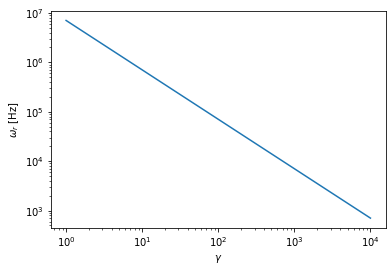

In [15]:
#gammas = np.logspace(0,4,41)

omegas = omega_r(B, gammas)

plt.loglog(gammas, omegas)

plt.xlabel('$\gamma$')
plt.ylabel('$\omega _r$ [{}]'.format(omegas.unit))

## Synchrotron Frequency

The synchrotron frequency is (see slide 40)
$$\nu_\mathrm{sync} = \frac{1}{2\pi} \left( \frac{U}{m c^2} \right)^2 \frac{qB}{m} \sin \phi$$
We are interested in electrons only, so we can keep the charge and mass fixed. Here is a function to do the calculation:

In [14]:
def nu_sync (U, B, phi = 90*u.degree) : 
    
    ret = U**2 * c.e.si * B * sin(phi) / 2 / pi / c.m_e**3 / c.c**4
    
    return ret.decompose().to(u.Hz)

The lecture example takes an assumed magnetic field in the Crab Nebula of $B = 5 \times 10^{-8}\,\mathrm{T}$.
We have seen that there are electrons with an energy of $U = 21\,\mathrm{TeV}$. The synchrotron frequency is

In [15]:
nu = nu_sync(21*u.TeV, 5e-8*u.T)

In [16]:
nu

<Quantity 2.36379662e+18 Hz>

And the photon energy is

In [17]:
E = nu*c.h

In [18]:
E.to(u.keV)

<Quantity 9.77587734 keV>

### Exercise
In order to fill the table on the tutorial sheet you need a function to calculate the electron energy $U$ in eV from the synchrotron frequency. Write a function to do this calculation.

In [19]:
def Eelectron_sync (nu, B, phi = 90*u.degree) :
    
    # fill in your code here
    E = 0*u.eV
    
    return E.to(u.eV)

Now we test the function.

In [20]:
Eelectron_sync(9.8*u.keV/c.h, B)

<Quantity 0. eV>

## Power Spectrum
We want to write a function to calculate the power spectrum of the synchrotron radiation of a mono-energetic electron. The equation (see slide 43) is
$$ P(\omega) = \frac{\sqrt{3}}{8 \pi^2} \frac{q^3 B \sin \phi}{\epsilon_0 c m} F\left( \frac{\omega}{\omega_c} \right)$$
with
$$ F(x) = x \int_x^\infty K_{5/3} (z) dz $$
and $K_{5/3} (z)$ being a modified Bessel function of the 2nd kind.

In order write a function for the entire power spectrum of an electron we will need some more modules:

In [21]:
import scipy.integrate as integrate
import scipy.special as special

The function $F(x)$ can be programmed as follows. (see https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html)

In [22]:
def F(x) :
    ## https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html
    
    #K53 = special.kv(5./3, x)
    result = x*integrate.quad(lambda z: special.kv(5./3,z), x, np.inf)[0]
    
    return result

But we need something that will work on a vector of x values:

In [23]:
def F_vec(x_vec) :
    
    integrateArray = []
    
    for x in x_vec :
        integrate = F(x)
        integrateArray.append(integrate)
    
    return integrateArray    

Here is a function to calculate the power radiated by an electron with energy $E$ in a magnetic field $B$ with a pitch angle $\phi$. nu can be a single frequency or an array of frequencies. Everything else must be a scalar.

In [24]:
def Psync(nu, E, B, phi = 90*u.degree) : 

    nu_over_nus = nu / nu_sync (E, B, phi)
    
    nu_over_nus = nu_over_nus.decompose().value
    
    if type(nu_over_nus) is np.ndarray :
        print('array mode')
        ret = np.array(F_vec(nu_over_nus))*u.one
    else :
        print('single mode')
        ret = F(nu_over_nus)*u.one


    ret *= sqrt(3)/8/pi**2 
    
    ret *= c.e.si**3 * B * sin(phi) / c.m_e / c.c / c.eps0.si


    return ret.to(u.W/u.Hz)


Let's calulcate the power for a range of frequencies. Let's use an electron energy of $U = 19\,\mathrm{TeV}$ and $B = 5\times10^{-8}\,\mathrm{T}$. 

In [37]:
U = 19*u.TeV
B = 5e-8*u.T

In [38]:
frequencies = np.logspace(13, 19, 601) * u.Hz

In [39]:
P = Psync(frequencies, U, B)

array mode


In [40]:
P

<Quantity [6.93140080e-35, 6.98477870e-35, 7.03856722e-35, 7.09276953e-35,
           7.14738879e-35, 7.20242821e-35, 7.25789099e-35, 7.31378039e-35,
           7.37009969e-35, 7.42685216e-35, 7.48404114e-35, 7.54166997e-35,
           7.59974202e-35, 7.65826068e-35, 7.71722938e-35, 7.77665157e-35,
           7.83653072e-35, 7.89687033e-35, 7.95767393e-35, 8.01894507e-35,
           8.08068733e-35, 8.14290432e-35, 8.20559968e-35, 8.26877706e-35,
           8.33244015e-35, 8.39659269e-35, 8.46123840e-35, 8.52638106e-35,
           8.59202448e-35, 8.65817249e-35, 8.72482895e-35, 8.79199775e-35,
           8.85968280e-35, 8.92788805e-35, 8.99661749e-35, 9.06587512e-35,
           9.13566498e-35, 9.20599113e-35, 9.27685768e-35, 9.34826875e-35,
           9.42022851e-35, 9.49274114e-35, 9.56581088e-35, 9.63944198e-35,
           9.71363872e-35, 9.78840542e-35, 9.86374643e-35, 9.93966615e-35,
           1.00161690e-34, 1.00932594e-34, 1.01709418e-34, 1.02492208e-34,
           1.03281010e-34

Let's make a plot of it:

Text(0, 0.5, 'P [W / Hz]')

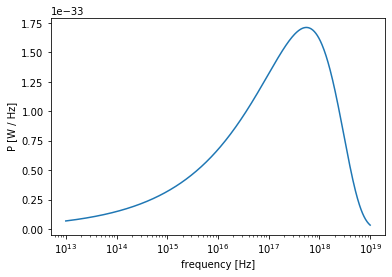

In [41]:
plt.plot(frequencies, P)

plt.xscale('log')

plt.xlabel('frequency [{}]'.format(frequencies.unit))
plt.ylabel('P [{}]'.format(P.unit))

In [50]:
P_fromEq = c.eps0.si * c.sigma_T * B**2 * U**2 / (c.c * c.m_e**2)

In [51]:
P_fromEq.to(u.W)

<Quantity 5.48529795e-14 W>

In [42]:
P_fromSpec = np.trapz(P, frequencies)

In [53]:
P_fromSpec

<Quantity 5.7499369e-15 W>

In [60]:
(P_fromSpec/P_fromEq).decompose() *4*pi

<Quantity 1.31726369>

### Exercise
Make plots similar to the plots on slide 45 of the lecture. Use 0.1, 1 and 10 TeV for the electron energy and a magnetic field of $B = 10^{-8}\,\mathrm{T}$ for the first plot, and an electron energy of $U = 10\,\mathrm{TeV}$ and magnetic fields of $10^{-10}\,\mathrm{T}$,$10^{-9}\,\mathrm{T}$, and $10^{-8}\,\mathrm{T}$.

In [ ]:
# for plot 1
U_1 = [0.1, 1, 10] *u.TeV
B_1 = 1e-8 * u.T

# fill in your code here

In [ ]:
# for plot 2
U_2 = 10 *u.TeV
B_2 = [1e-10, 1e-9, 1e-8] * u.T

# fill in your code here

## Emitted Power in the Relativistic Case 

We will use the equation from slide 52 of the lecture. Electron energy and magnetic field are as above:

In [30]:
U

<Quantity 19. TeV>

In [31]:
B

<Quantity 5.e-08 T>

As the electron is highly relativistic we can set $\beta$ to $1$.

In [32]:
beta = 1

In [33]:
P = 2./3 * c.eps0.si * c.sigma_T * beta**2 / (c.c * c.m_e**2) * B**2 * U**2

In [34]:
P.to(u.W)

<Quantity 3.6568653e-14 W>

In [61]:
B

<Quantity 5.e-08 T>

In [62]:
(u.J).decompose()

Unit("kg m2 / s2")

In [66]:
uu = u.kg**3 * u.m*4 / (u.C * u.s*4 *u.eV)

In [68]:
uu.to(u.eV)

UnitConversionError: 'kg3 m / (C eV s)' and 'eV' (energy) are not convertible